# **SETUP**

1) continue Image Classification problem from previous class which aims to classify microscopy images into good, empty or blurred by: 
1. gathering ~1000 samples per class for training the model; 
2. using https://supervise.ly for image augmentation to generate more samples;
3. using CNN and transfer learning

2) denoise blurred images using auto-encoder
1. please see https://blog.keras.io/building-autoencoders-in-keras.html
2. Simple structure could be: blurry input images -> feed into CNN (this could be transfer learning) -> train x - noise image  y - clean image -> Fully connected NN -> reconstructed clean image

3) track patches from fluorescence images and use a visualization tool


In [0]:
import tensorflow as tf
import keras
from platform import python_version

Using TensorFlow backend.


In [0]:
keras.__version__

'2.2.5'

In [0]:
tf.__version__

'1.15.0'

In [0]:
print(python_version())

3.6.9


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras import applications
import tensorflow as tf
from tqdm import tqdm
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import random
from shutil import copyfile
import os
import gc
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras import backend as K

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import style
import seaborn as sns
from keras.callbacks import ModelCheckpoint
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

In [0]:
from google.colab import drive
drive.mount('/content/drive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd /content/drive/My Drive/Deep Learning/Project/dataset1
#%cd /content/drive/My Drive/Deep Learning/Project/dataset2
#%cd /content/drive/My Drive/Deep Learning/Project/dataset3

!ls

/content/drive/My Drive/Deep Learning/Project/dataset1
blurred  empty	good  models


# **Data Preparation**

In [0]:
X=[]
y=[]
IMG_SIZE=150
GOOD_DIR='good'
EMPTY_DIR='empty'
BLURRED_DIR='blurred'

def assigning_label(img,image_type):
    return image_type

def make_train_data(image_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assigning_label(img,image_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        y.append(str(label))

In [0]:
#create training data
make_train_data('good',GOOD_DIR)
make_train_data('empty',EMPTY_DIR)
make_train_data('blurred',BLURRED_DIR)
print(len(X))

100%|██████████| 3072/3072 [11:32<00:00,  5.04it/s]

7032


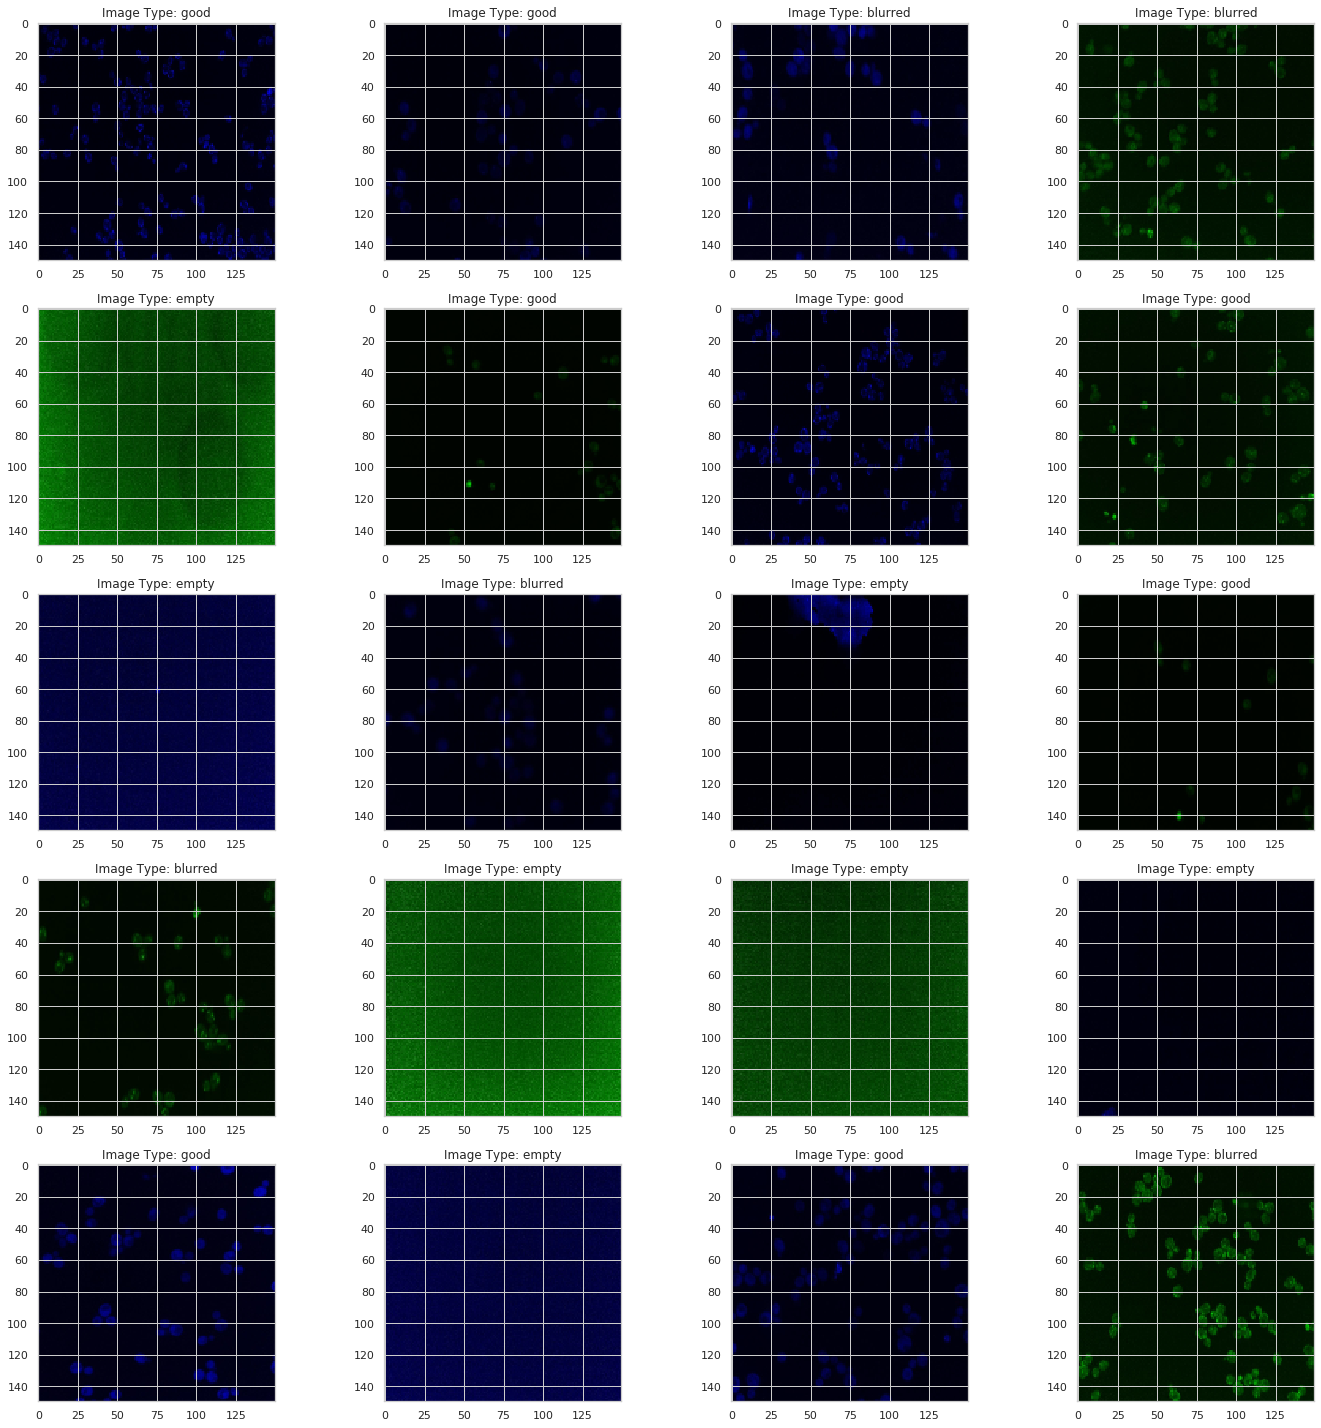

In [0]:
import random as rn
fig,ax=plt.subplots(5,4)
fig.set_size_inches(20,20)
for i in range(5):
    for j in range (4):
        l=rn.randint(0,len(y))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Image Type: '+y[l])
        
plt.tight_layout()

In [0]:
from sklearn.preprocessing import LabelEncoder

labelEncoder=LabelEncoder()
y=labelEncoder.fit_transform(y)
y=to_categorical(y,5)
X=np.array(X)
X=X/255

In [0]:
X.shape

(7032, 150, 150, 3)

In [0]:
y.shape

(7032, 5)

In [0]:
X_train_val,X_test,y_train_val,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
X_train,X_val,y_train,y_val=train_test_split(X_train_val,y_train_val,test_size=0.25,random_state=42)

In [0]:
X_train.shape

(3955, 150, 150, 3)

In [0]:
y_train.shape

(3955, 5)

# **BASE MODEL VGG16**
1. All blocks in VGG16
2. Using 150x150 as input shape

In [0]:
image_w, image_h = 150,150
model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_w, image_h, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# **Discrete Model Definitions with VGG16 Base**


##Model 1 Definition - VGG16 Base (all layers frozen)
1. imported with top layers cut off, 
2. all layers frozen 
3. new fully connected layers are added.

In [0]:
for layer in model.layers:
    layer.trainable = False
    
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [0]:
def Revised_1_fn(learn_rate=0.01): 
    last = model.output
    x = Flatten()(last)
    x = Dense(256, activation='relu', name='new_fc1', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    preds = Dense(5, activation='softmax')(x)

    Revised_Model_1 = Model(model.input, preds)
    Revised_Model_1.summary()
    Revised_Model_1.compile(loss = "categorical_crossentropy", optimizer = 'Adam', metrics=["accuracy"])
    return Revised_Model_1

## Model 2 Definition - VGG16 Base (last block unfrozen)
1. Unfreeze last block (block 5)

In [0]:
for layer in model.layers[15:]:
    layer.trainable = True
     
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [0]:
def Revised_2_fn(learn_rate=0.01):
    last = model.output
    x = Flatten()(last)
    x = Dense(256, activation='relu', name='new_fc1', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    preds = Dense(5, activation='softmax')(x)

    Revised_Model_2 = Model(model.input, preds)
    Revised_Model_2.summary()
    Revised_Model_2.compile(loss = "categorical_crossentropy", optimizer = 'Adam', metrics=["accuracy"])
    return Revised_Model_2

## Model 3 Definition - VGG16 Base (Unfreeze all layers)
1. Unfreeze all blocks

In [0]:
for layer in model.layers:
    layer.trainable = True
     
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [0]:
def Revised_3_fn(learn_rate=0.01): 
    last = model.output
    x = Flatten()(last)
    x = Dense(256, activation='relu', name='new_fc1', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    preds = Dense(5, activation='softmax')(x)

    Revised_Model_3 = Model(model.input, preds)
    Revised_Model_3.summary()
    Revised_Model_3.compile(loss = "categorical_crossentropy", optimizer = 'Adam', metrics=["accuracy"])
    return Revised_Model_3

# **Evaluate Models**
1. Evaluate
2. Save .h5 models to ./models folder


## Model 1

1. Train, 
2. Fine-Tune using Hyper parameters and 
3. Evaluate the first model and save

### Grid Search with Early stopping


In [0]:
es = EarlyStopping(monitor='val_acc', verbose=2, patience=25)
filepath = "./models/model_1.h5"
mc = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)

Hyp_Model_1 = KerasClassifier(build_fn=Revised_1_fn)

### Train with Hyper-Parameters

1. Learn Rate
2. Batch Size
3. Epochs
4. Save final model in .h5 format




In [0]:
learn_rate = [0.01]
batch_size = [32,75,100]
epochs = [5]

param_grid = dict(batch_size=batch_size, epochs=epochs, learn_rate = learn_rate)
randSearch_1 = GridSearchCV(estimator = Hyp_Model_1, param_grid=param_grid, cv=5)

In [0]:
new_grid_1 = randSearch_1.fit(X_train,y_train, validation_data = (X_val, y_val), verbose=2,callbacks=[es,mc])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________

### Load saved model and Evaluate



In [0]:
from keras.models import load_model
final_model_1 = load_model('./models/model_1.h5')

In [0]:
# evaluate the model on validation set
val_scores = []
val_scores_1 = final_model_1.evaluate(X_val,y_val, verbose=0)
print("%s: %.2f%%" % (final_model_1.metrics_names[1], val_scores_1[1]*100))
val_scores.append(val_scores_1[1] * 100)

acc: 86.81%


In [0]:
# evaluate the model
finalscores = []
final_scores_1 = final_model_1.evaluate(X_test,y_test, verbose=0)
print("%s: %.2f%%" % (final_model_1.metrics_names[1], final_scores_1[1]*100))
finalscores.append(final_scores_1[1] * 100)

acc: 87.66%


In [0]:
import gc
gc.collect()

129

## Model 2

1. Train, 
2. Fine-Tune using Hyper parameters and 
3. Evaluate the first model and save

### Grid Search with Early stopping


In [0]:
es = EarlyStopping(monitor='val_acc', verbose=2, patience=5)
mc = ModelCheckpoint('./models/model_2.h5', monitor='val_acc', verbose=2, save_best_only=True)

Hyp_Model_2 = KerasClassifier(build_fn=Revised_2_fn)

### Train with Hyper-Parameters

1. Learn Rate
2. Batch Size
3. Epochs
4. Save final model in .h5 format




In [0]:
learn_rate = [0.01]
batch_size = [32,75,100]
epochs = [5]

param_grid = dict(batch_size=batch_size, epochs=epochs, learn_rate = learn_rate)
randSearch_2 = GridSearchCV(estimator = Hyp_Model_2, param_grid=param_grid, cv=5)

In [0]:
new_grid_2 = randSearch_2.fit(X_train,y_train,validation_data = (X_val, y_val), verbose=2,callbacks=[es,mc])

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0  

### Load saved model and Evaluate



In [0]:
from keras.models import load_model
final_model_2 = load_model('./models/model_2.h5')

In [0]:
val_scores_2 = final_model_2.evaluate(X_val,y_val, verbose=0)
print("%s: %.2f%%" % (final_model_2.metrics_names[1], val_scores_2[1]*100))
val_scores.append(val_scores_2[1] * 100)

acc: 89.31%


In [0]:
final_scores_2 = final_model_2.evaluate(X_test,y_test, verbose=0)
print("%s: %.2f%%" % (final_model_2.metrics_names[1], final_scores_2[1]*100))
finalscores.append(final_scores_2[1] * 100)

acc: 87.94%


In [0]:
import gc
gc.collect()

22

## Model 3

1. Train, 
2. Fine-Tune using Hyper parameters and 
3. Evaluate the first model and save


### Grid Search with Early stopping


In [0]:
es = EarlyStopping(monitor='val_acc', verbose=2, patience=5)
mc = ModelCheckpoint('./models/model_3.h5', monitor='val_acc', verbose=2, save_best_only=True)

Hyp_Model_3 = KerasClassifier(build_fn=Revised_3_fn)

### Train with Hyper-Parameters

1. Learn Rate
2. Batch Size
3. Epochs
4. Save final model in .h5 format




In [0]:
learn_rate = [0.01]
batch_size = [32,75,100]
epochs = [5]

param_grid = dict(batch_size=batch_size, epochs=epochs, learn_rate = learn_rate)
randSearch_3 = GridSearchCV(estimator = Hyp_Model_3, param_grid=param_grid, cv=5)

In [0]:
new_grid_3 = randSearch_3.fit(X_train,y_train,validation_data = (X_val, y_val), verbose=2,callbacks=[es,mc])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

### Load saved model and Evaluate



In [0]:
from keras.models import load_model
final_model_3 = load_model('./models/model_3.h5')

In [0]:
val_scores_3 = final_model_3.evaluate(X_val,y_val, verbose=0)
print("%s: %.2f%%" % (final_model_3.metrics_names[1], val_scores_3[1]*100))
val_scores.append(val_scores_3[1] * 100)

acc: 89.31%


In [0]:
final_scores_3 = final_model_3.evaluate(X_test,y_test, verbose=0)
print("%s: %.2f%%" % (final_model_3.metrics_names[1], final_scores_3[1]*100))
finalscores.append(final_scores_3[1] * 100)

acc: 87.94%


In [0]:
import gc
gc.collect()

133

# **Scoring**
1. Compare Scores for each model


In [0]:
val_scores

[86.8081880212282, 89.31008340103143, 89.31008340103143]

In [0]:
finalscores

[87.65642777237875, 87.94084181828981, 87.94084181828981]

Text(0.5, 1.0, 'Bar Plot of Test Accuracy for all 3 Models')

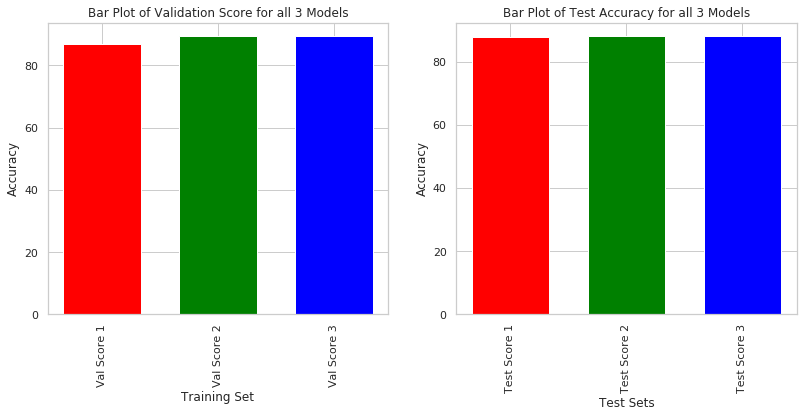

In [0]:
plt.figure(figsize=(25, 5))

plt.subplot(141)
y_hits = val_scores
x_hits = ['Val Score 1' ,'Val Score 2' ,'Val Score 3']
plt.xticks(rotation = 'vertical')
width = 1/1.5
plt.bar(x_hits, y_hits, width, color=['red', 'green', 'blue'])
plt.xlabel('Training Set')
plt.ylabel('Accuracy')
plt.title('Bar Plot of Validation Score for all 3 Models')

plt.subplot(142)
y_hits = finalscores
x_hits = ['Test Score 1','Test Score 2','Test Score 3']
plt.xticks(rotation = 'vertical')
width = 1/1.5
plt.bar(x_hits, y_hits, width, color=['red', 'green', 'blue'])
plt.xlabel('Test Sets')
plt.ylabel('Accuracy')
plt.title('Bar Plot of Test Accuracy for all 3 Models')

# **Conclusions**
 



Based on the scoring above, model 2 is the best model.

Now we predict on Test Data using the best model and Classify the images correctly identified and incorrectly classified


In [0]:
pred=final_model_1.predict(X_test)
pred_digits=np.argmax(pred,axis=1)
act_digits = np.argmax(y_test,axis=1)

In [0]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(act_digits[i]==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not act_digits[i]==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

## Correctly Classified Images


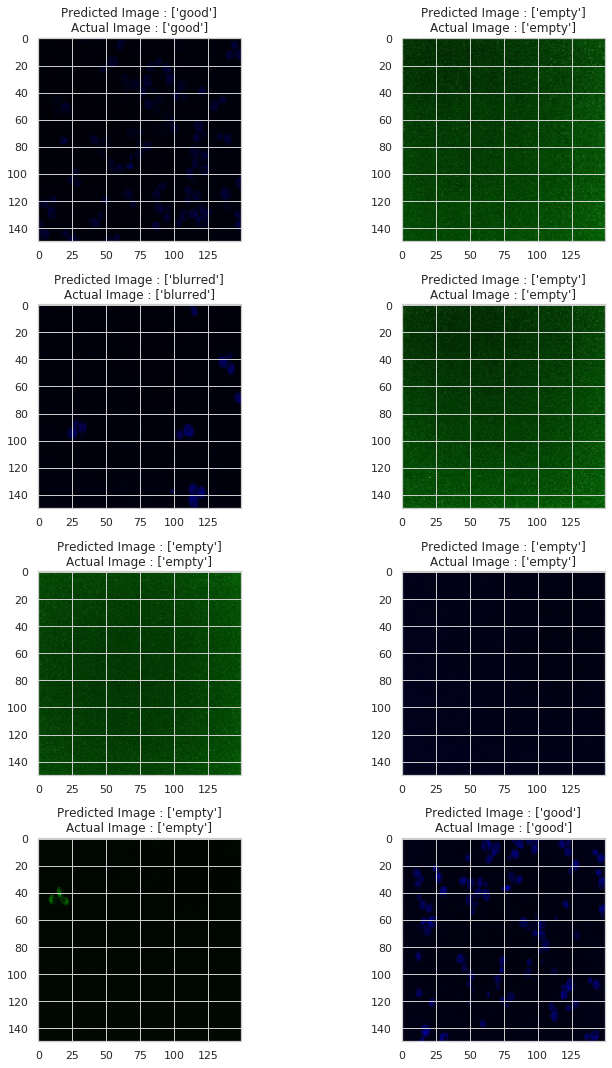

In [0]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(X_test[prop_class[count]])
        ax[i,j].set_title("Predicted Image : "+str(labelEncoder.inverse_transform([pred_digits[prop_class[count]]])) +"\n"+"Actual Image : "+str(labelEncoder.inverse_transform([act_digits[prop_class[count]]])))
        plt.tight_layout()
        count+=1

## Incorrectly Classified Images


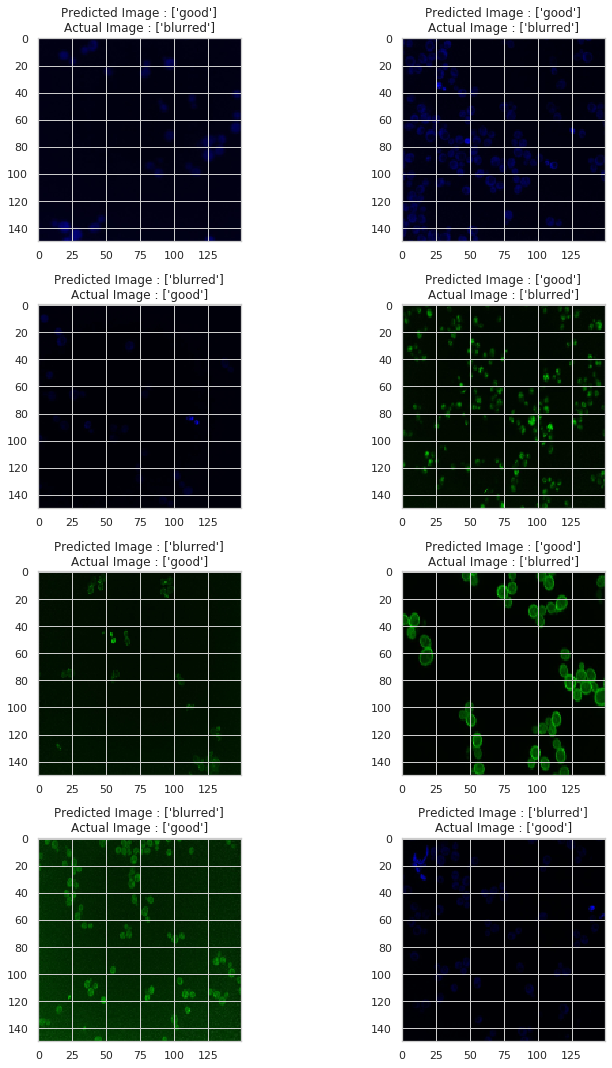

In [0]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(X_test[mis_class[count]])
        ax[i,j].set_title("Predicted Image : "+str(labelEncoder.inverse_transform([pred_digits[mis_class[count]]])) +"\n"+"Actual Image : "+str(labelEncoder.inverse_transform([act_digits[mis_class[count]]])))
        plt.tight_layout()
        count+=1

## Summary

Based on the graph above, model 2 yields the highest accuracy.

The default VGG16 model has been trained using image-based datasets and has been proven to deliver good results on its own but shows the lowest accuracy.

As soon as we unfreeze layers, the model starts becoming trainable; back propogation is enabled for a few layers in the model. This results in a change in the weights for the 5th Block (Model 2) and does impact the model to show the highest accuracy.

Model 3 eventually turns out to yield the middle accuracy; all layers are trainable. As more trainable layers using certain activation functions are added to neural networks, the gradients of the loss function approaches zero. This makes the neural network hard to train. Much more data would be needed to train the third model in order to achieve a better accuracy.
